In [1]:
!pip install transformers

* How to prepare a large dataset from the Hub
* How to use the high-level Trainer API to fine-tune a model
* How to use a custom training loop
* How to leverage the 🤗 Accelerate library to easily run that custom training loop on an

In [ ]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
print(batch)
# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2023,  2607,  2003,  6429,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


* To get better results, you will need to prepare a bigger dataset.
* the MRPC (Microsoft Research Paraphrase Corpus) dataset
* The dataset consists of 5,801 pairs of sentences, with a label indicating if they are paraphrases or not (i.e., if both sentences mean the same thing).

## Loading a dataset from the Hub

* The Hub doesn’t just contain models; it also has multiple datasets in lots of different languages. 


* You can browse the datasets here, and we recommend you try to load and process a new dataset once you have gone through this section (see the general documentation here).https://huggingface.co/docs/datasets/loading_datasets.html#from-the-huggingface-hub

* The 🤗 Datasets library provides a very simple command to download and cache a dataset on the Hub

In [4]:
! pip install datasets

     |████████████████████████████████| 542 kB 14.2 MB/s 
     |████████████████████████████████| 118 kB 25.0 MB/s 
     |████████████████████████████████| 243 kB 35.1 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")#Microsoft Research Paraphrase Corpus
raw_datasets

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

we get a DatasetDict object which contains the training set, the validation set, and the test set. Each of those contains several columns (sentence1, sentence2, label, and idx) and a variable number of rows, which are the number of elements in each set (so, there are 3,668 pairs of sentences in the training set, 408 in the validation set, and 1,725 in the test set).

* We can access each pair of sentences in our raw_datasets object by indexing, like with a dictionary:

In [3]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'idx': 0,
 'label': 1,
 'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .'}

* The labels are already integers, so we won’t have to do any preprocessing there
* To know which integer corresponds to which label, we can inspect the features of our raw_train_dataset. 

In [4]:
raw_train_dataset.features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], names_file=None, id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None)}

## Observation
* label is of type ClassLabel
* 0 corresponds to not_equivalent, 
* 1 corresponds to equivalent

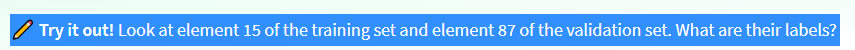

In [5]:
raw_train_dataset[15]

{'idx': 16,
 'label': 0,
 'sentence1': 'Rudder was most recently senior vice president for the Developer & Platform Evangelism Business .',
 'sentence2': 'Senior Vice President Eric Rudder , formerly head of the Developer and Platform Evangelism unit , will lead the new entity .'}

In [6]:
raw_train_dataset[87]

{'idx': 100,
 'label': 1,
 'sentence1': 'Tuition at four-year private colleges averaged $ 19,710 this year , up 6 percent from 2002 .',
 'sentence2': 'For the current academic year , tuition at public colleges averaged $ 4,694 , up almost $ 600 from the year before .'}